## Continuous-time Noisy Voter Model (CNVM)

This package provides an efficient implementation of the CNVM, which is a dynamical system on a network of $N$ nodes (agents).
Each node is endowed with one of $M$ discrete opinions. Thus, the system state is given by a vector $x \in \{1,\dots,M\}^N$, where $x_i$ describes the opinion of node $i$.
Each node's opinion $x_i \in \{1,\dots,M\}$ changes over time according to a continuous-time Markov chain (Markov jump process).
Given the current system state $x$, the generator matrix $Q^i$ of the continuous-time Markov chain associated with node $i$ is defined as
$$ Q^i \in \mathbb{R}^{M \times M},\quad (Q^i)_{m,n} := r_{m,n} \frac{d_{i,n}(x)}{(d_i)^\alpha} + \tilde{r}_{m,n},\ m\neq n, $$
where $d_{i,n}(x)$ denotes the number of neighbors of node $i$ with opinion $n$ and $d_i$ is the degree of node $i$. The matrices $r, \tilde{r} \in \mathbb{R}^{M \times M}$ and $\alpha \in \mathbb{R}$ are model parameters.

Thus, the transition rates $(Q^i)_{m,n}$ consist of two components. The first component $r_{m,n} \frac{d_{i,n}(x)}{(d_i)^\alpha}$ describes at which rate node $i$ gets ``infected'' by nodes in its neighborhood.
The second part $\tilde{r}_{m,n}$ describes transitions that are independent from the neighborhood.

It should be noted that after a node switches its opinion due to the above dynamics, the system state $x$ changes and hence all the generator matrices $Q^i$ may change as well.
The model is simulated using a Gillespie-like algorithm that generates statistically correct samples.

Let us conduct an example simulation of the CNVM. We begin by doing the necessary imports:

In [1]:
# imports
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

In this example, we will have $N=100$ agents and $M=3$ different opinions. The rates $r_{m,n}$ and $\tilde{r}_{m,n}$ have to be specified for each pair $m\neq n$ and are thus defined as $M \times M$ arrays.

In [2]:
num_agents = 100
num_opinions = 3

r = np.array([[0, .8, .2],
              [.2, 0, .9],
              [.8, .3, 0]])
r_tilde = 0.01 * np.array([[0, .9, .8],
                           [.7, 0, .9],
                           [.9, .7, 0]])

Now we specify the network structure using the `networkx` package. In this example, we sample a random graph using the Erdös-Renyi model.
It should be noted that graphs with isolated vertices are not allowed in the CNVM model.

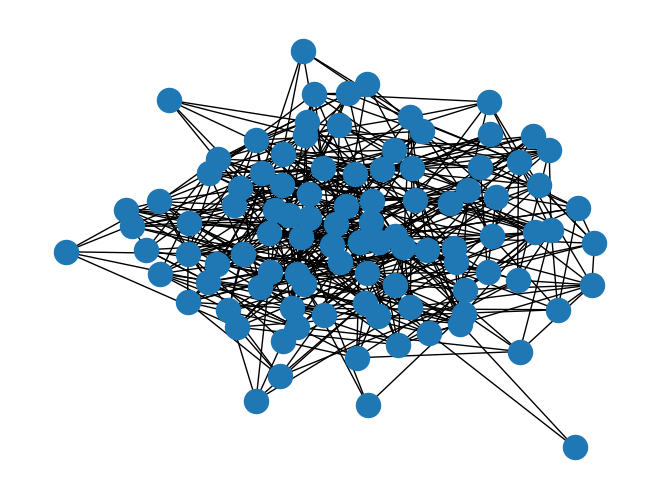

In [3]:
network = nx.erdos_renyi_graph(num_agents, p=0.1)
nx.draw(network)
plt.show()

We summarize the model parameters in the class `Parameters`.

Providing `num_opinions` and the rates `r` and `r_tilde` is required to create an instance of `Parameters`. Moreover, it is required to either specify a `network` (which we do), or a `network_generator` (from `cnvm.network_generators`), or `num_agents` (in which case a complete network is used).
The parameter `alpha` is optional with default value 1.

In [4]:
from sponet import CNVMParameters, CNVM
params = CNVMParameters(num_opinions=num_opinions,
                    network=network,
                    r=r,
                    r_tilde=r_tilde,
                    alpha=1)

Now we construct the model using the `CNVM` class and the parameters that we have defined before. We execute the simulation by calling the method `CNVM.simulate`. Note that the first call of `CNVM.simulate` takes longer than subsequent calls because the simulation code is just-in-time compiled using `numba`.

In [5]:
model = CNVM(params)

# initial state
x_init = np.concatenate([0 * np.ones(int(20 * num_agents / 100)),
                         1 * np.ones(int(50 * num_agents / 100)),
                         2 * np.ones(int(30 * num_agents / 100))])

# simulation from t=0 to t=t_max                 
t_max = 200

# execute simulation
t, x = model.simulate(t_max, x_init)
print(t.shape)  # time stamps of jumps
print(x.shape)  # system state after each jump

(18365,)
(18365, 100)


In order to visualize the results of the simulation, we calculate an aggregate state called the *opinion shares*. The opinion shares are simply the numbers of agents of each discrete opinion. For example, in our initial state we had 20 agents with opinion 0, 50 with opinion 1, and 30 with opinion 2.

In [6]:
from sponet.collective_variables import OpinionShares
opinion_shares = OpinionShares(num_opinions)
c = opinion_shares(x)
print(c.shape)

(18365, 3)


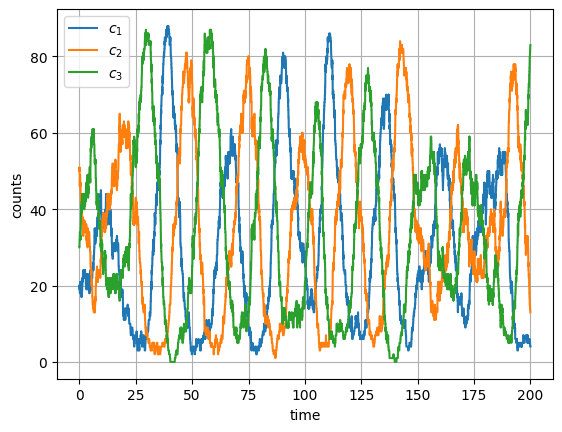

In [7]:
for i in range(c.shape[1]):
    plt.plot(t, c[:, i], label=f"$c_{i+1}$")
plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("counts")
plt.show()

It is often required to perform many simulations for many initial states to approximate important statistics. We provide the utility function `sample_many_runs` for that purpose:

In [8]:
from sponet import sample_many_runs

initial_states = np.array([x_init])
t, c = sample_many_runs(params,
                        initial_states,
                        t_max,
                        num_timesteps=200,
                        num_runs=5000,
                        collective_variable=opinion_shares,
                        n_jobs=-1)
print(t.shape)
print(c.shape)

(200,)
(1, 5000, 200, 3)


The output c has the shape (# initial states, # samples, # timesteps, # opinions). Multiprocessing is enabled via n_jobs=-1 and disabled via n_jobs=None.

We plot the ensemble average:

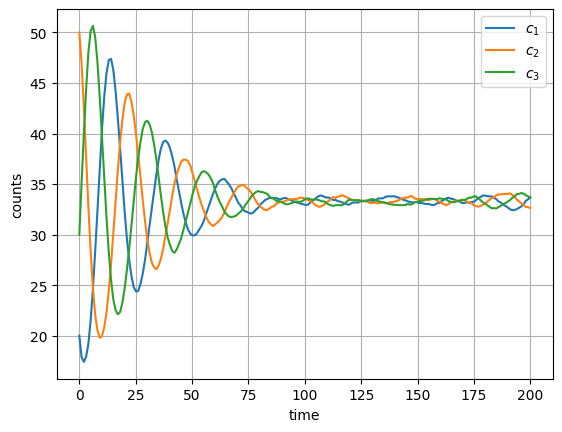

In [9]:
for i in range(c.shape[3]):
    plt.plot(t, np.mean(c[0, :, :, i], axis=0), label=f"$c_{i+1}$")
plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("counts")
plt.show()